In [2]:
import re
import spacy
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from catboost import CatBoostRegressor, CatBoostClassifier
import matplotlib.pyplot as plt
import xgboost

In [3]:
data_path = 'data/processed_data.csv'

In [4]:
df = pd.read_csv(data_path)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['rank'], random_state=42)

In [6]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

Наивные методы

In [86]:
reg = LinearRegression().fit(X_train_vect, y_train)

In [91]:
y_predict = reg.predict(X_test_vect)
mean_squared_error(y_predict, y_test)

23.00236116024186

In [102]:
print(reg.predict(X_test_vect[4]))
print(reg.predict(X_test_vect[1]))

[5.8668018]
[-3.99628881]


Очень плохо, учитывая, что у нас значения в диапазоне от 0 до 1. Собственно другого от линейной регрессии и не ожидалось.

In [105]:
reg_tree = DecisionTreeRegressor(random_state=0).fit(X_train_vect, y_train)

In [198]:
y_test[0]

1.0

In [200]:
y_predict = reg_tree.predict(X_test_vect)
print('MSE metric', mean_squared_error(y_predict, y_test), end = '\n\n')
print(reg_tree.predict(X_test_vect[0]), y_test[0])
print(df['text'][0], end = '\n\n')
print(reg_tree.predict(X_test_vect[1]), y_test[4])
print(df['text'][4], end = '\n\n')
print(reg_tree.predict(X_test_vect[2]), y_test[12])
print(df['text'][12], end = '\n\n')
print(reg_tree.predict(X_test_vect[3]), y_test[20])
print(df['text'][20], end = '\n\n')

MSE metric 0.2756642367160156

[0.28571429] 1.0
problem simple piece code write javascript help here think understand far javascript variable undefined value evaluate false boolean operation operator comparation ask value comparable regardless type find exercise file online course try not get result expect lesson main problem compare value value false solution value decide write short code order try m get mixed result example expect js code generate identical alert foo equal false instead statement return foo equal false second return expect foo equal false write var foo undefine foo false alertfoo equal false alertfoo equal false javascript execute row foo alertfoo equal false javascript execute row alertfoo equal false afaik ifs work infact try replace line value var foo undefine var foo 0 work expect 0 value evaluate false remember tell m wrong $sep$ algorithm abstract equality comparison algorithm not simply assume outcome know algorithm need know detail work example null undefined

В целом уже получше, видно, что на примере из валидации отделили менее релевантный ответ от более, хотя в данных случаях, это просто сделать по размеру ответа.

Менее наивные методы

In [12]:
model_catboost = CatBoostRegressor(iterations=1000,
                           task_type="CPU",
                           devices='0')
model_catboost.fit(X_train_vect, y_train, verbose=False)

In [13]:
y_predict = model_catboost.predict(X_test_vect)
mean_squared_error(y_predict, y_test)

0.1383833777997369

In [18]:
evals_result = model_catboost.get_evals_result()
train_loss = evals_result['learn']['RMSE']

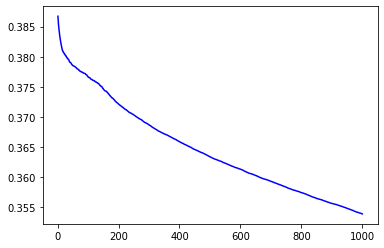

In [22]:
iterations = np.arange(1, len(train_loss) + 1)
plt.plot(iterations, train_loss, label='Training Loss', color='blue')
plt.show()

Точность существенно улучшилась

In [7]:
model_xgboost = xgboost.XGBRegressor(n_estimators=1000)
model_xgboost.fit(X_train_vect, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
y_predict = model_xgboost.predict(X_test_vect)
mean_squared_error(y_predict, y_test)

0.1383833777997369

Видимо существенно улучшить точность не получится

Следующая задача, которую хотелось бы решить - это понять, будет ответ одобрен автором или нет(это обозначается зеленой галочкой на StackOveflow)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['accepted'], random_state=42)

In [9]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [8]:
log_reg = LogisticRegression().fit(X_train_vect, y_train)

In [9]:
y_predict = log_reg.predict(X_test_vect)
f1_score(y_predict, y_test)

0.010301692420897719

Низкое качество, ожидаемо

In [10]:
tree_classifer = DecisionTreeClassifier().fit(X_train_vect, y_train)

In [11]:
y_predict = tree_classifer.predict(X_test_vect)
f1_score(y_predict, y_test)

0.16199501246882794

In [15]:
model_catboost = CatBoostClassifier(iterations=1000,
                           task_type="CPU",
                           devices='0')
model_catboost.fit(X_train_vect, y_train, verbose=False)

Уже существенно лучше, хотя возможно тут принцип такой же, как и у регрессии, просто по количеству слов

In [16]:
y_predict = model_catboost.predict(X_test_vect)
f1_score(y_predict, y_test)

0.012143514259429623